<a href="https://colab.research.google.com/github/ZhiCLiu/DS-WorkShop/blob/main/MNIST_WalkThrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt 

import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

We'll start off by downloading the MNIST dataset. These consist of pairs of (black & white images, labels)...so for instance, (an image of the number 3, 3). The dataset is available in torchvision. We are downloading it to a new "data" directory. 

The raw images would be pillow files, so to use them in torch, we are applying the ToTensor transform. We'll explore transforms in depth later.


In [ ]:
train_dataset = MNIST(root='data/', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = MNIST(root='data/', train=False, download=True, transform=transforms.ToTensor())

Let's take a look at the first example in the training dataset, train_dataset[0]. This is a tuple, with the first entry being an image (transformed to a torch tensor) and a single numerical label corresponding to the image.

A general image is represented via the shape of [height, width, channels]. The height and width are the dimensions of the image. The channels represent the red, green and blue color intensities in a generic color image. Thus each pixel (picture element) in an image is an (r,g,b) tuple...consisting of three numbers denoting the intensities of red, green and blue. The combination of these 3 determines the color of the pixel. All these pixels over the entire height and width give a pattern of colors, that you percieve as a face/sunset/etc.

Here, the image tensor is shaped as [chanels, height, width], ie channels-first format. Most other libraries expect channelns last or none, so we'll make simplifications while plotting in matplotlib.

5


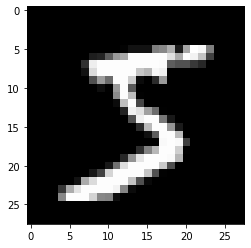

In [ ]:
xb = train_dataset[0][0]
plt.imshow(xb[0,...], cmap='gray');
print(train_dataset[0][1])

Now, we'll create a training and testing/validation data loader. These shuffle the data every epoch and feed-in batches (smaller sized chunks) of data to the model during training.

We want this shuffling to offset any false patterns in the data during training, but do not need it during validation/test.

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dl = DataLoader(validation_dataset, batch_size=32)

Here, you'll see that each batch has an (xb, yb) pair.

The xb is shaped [batch_size, channels, height, width].

The corresponndig yb is shaped [batch_size].

In [ ]:
for xb,yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


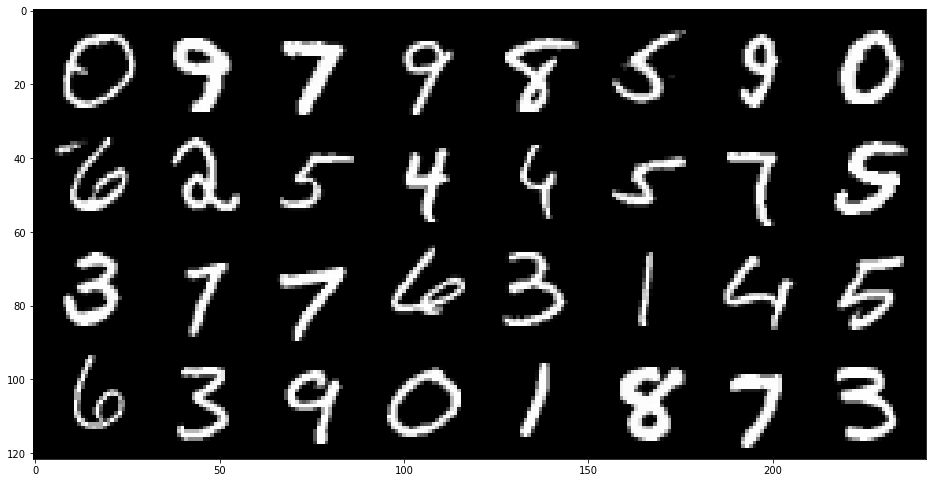

In [ ]:
grid_img = torchvision.utils.make_grid(xb, nrow=8)
plt.figure(figsize=(16,16))
plt.imshow(grid_img.permute(1, 2, 0))

Now, we'll define our model class just like earlier.

A key point to remember is that the individual images are 3D tensors (of shape [1,28,28]). The nn.Linear layers define matrix multiplication of batches of Vectors with their weight matrices. 

Thus, we need to reshape (or unravel) our inputs to vectors of length heightxwidthxchannels. This enables the fully connected neural network to process these inputs and train. However, it loses a lot of the local structure of the image. For instance, after unraveling, one part of the eye pixels may be at the beginig of the vector, another part may be in the middle and the last part in the end! We'll see how to redress that using convolutions later.

In [ ]:
class MyModel(nn.Module):
  def __init__(self, input_shape=28*28, hidden_shape=256, output_shape=10):
    super().__init__()
    self.layer1 = nn.Linear(input_shape, hidden_shape)
    self.layer2 = nn.Linear(hidden_shape, output_shape)
    self.relu = nn.ReLU()

  def forward(self, xb):
    xb = torch.reshape(xb, (xb.shape[0], -1))
    x = self.layer1(xb)
    x = self.relu(x)
    out = self.layer2(x)
    return out

The model outputs 10 numbers, denoting the scores for each class (from 0,1,2..,9). These can be passed through a softmax function that exponetiate and then normalizes them from scores of each class to probabilities of each class.

Our final singleton answer will be the class with the highest probability.

In [ ]:
test_model = MyModel()
temp = test_model(xb)
print(xb.shape)
print(temp.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


While we cant use accuracy as an objective to train (the maximum operator in not differentiable and we need a function whose derivative we can derive), we'd still like to report this metric to laypersons. So, we define a small helper function that calculates accuracy over each batch of predictions.

In [ ]:
def get_accuracy(scores, labels):
  softmax_scores = F.softmax(scores, dim=1)
  _, predictions = torch.max(softmax_scores, dim=1)
  acc = torch.sum(predictions == labels).item()/len(labels)
  return acc

We test this for ann untrained neural network. The expected answer should be around 0.1...because there are 10 classes of numbers and a random guess would have 1/10 chance of being correct.

In [ ]:
get_accuracy(temp, yb)

0.03125

We will use the numti-dimension equivalent of the logistic regression loss, referred to as the softmax loss. for each pair of prediction, label...this loss is $- \frac{1}{m}\sum y_i \times log(\hat{y}_i)$.

In [ ]:
lr = 0.001
num_epochs = 20
model = MyModel()

loss_fn = F.cross_entropy
opt = SGD(model.parameters(),lr=lr)

In [ ]:
for epoch in range(num_epochs):
  model.train()
  for xb, yb in train_dl:
    outputs = model(xb)
    loss = loss_fn(outputs, yb)
    opt.zero_grad()
    loss.backward()
    opt.step()

  model.eval()
  batch_accuracies =[]
  for xb, yb in validation_dl:
    outputs = model(xb)
    batch_accuracy = get_accuracy(outputs, yb)
    batch_accuracies.append(batch_accuracy)

  epoch_accuracy = torch.tensor(batch_accuracies).mean().item()
  print(f"Epoch: {epoch+1} \t Accuracy: {epoch_accuracy}")

Epoch: 0 	 Accuracy: 0.7330271601676941
Epoch: 1 	 Accuracy: 0.7896365523338318
Epoch: 2 	 Accuracy: 0.8309704661369324
Epoch: 3 	 Accuracy: 0.8527356386184692
Epoch: 4 	 Accuracy: 0.8675119876861572
Epoch: 5 	 Accuracy: 0.8753993511199951
Epoch: 6 	 Accuracy: 0.881489634513855
Epoch: 7 	 Accuracy: 0.887180507183075
Epoch: 8 	 Accuracy: 0.8920726776123047
Epoch: 9 	 Accuracy: 0.8943690061569214
Epoch: 10 	 Accuracy: 0.8977635502815247
Epoch: 11 	 Accuracy: 0.898861825466156
Epoch: 12 	 Accuracy: 0.9020566940307617
Epoch: 13 	 Accuracy: 0.9032548069953918
Epoch: 14 	 Accuracy: 0.9050519466400146
Epoch: 15 	 Accuracy: 0.9052516222000122
Epoch: 16 	 Accuracy: 0.9069488644599915
Epoch: 17 	 Accuracy: 0.9092451930046082
Epoch: 18 	 Accuracy: 0.9099441170692444
Epoch: 19 	 Accuracy: 0.9108426570892334


Prediction: 8
Truth:  8


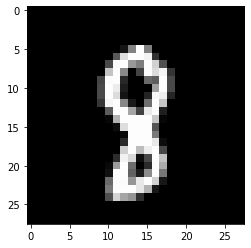

In [ ]:
model.eval()
test_image = validation_dataset[1007][0]
test_label = validation_dataset[1007][1]
outputs = model(test_image)
softmax_scores = F.softmax(outputs, dim=1)
_, predictions = torch.max(softmax_scores, dim=1)

print("Prediction:", predictions.item())
print("Truth: ", test_label)
plt.imshow(test_image[0,...], cmap='gray');

In [ ]:
torch.save(model.state_dict(), 'my_model_1.pth')

In [ ]:
new_model = MyModel()
new_model.load_state_dict(torch.load('my_model_1.pth'))

<All keys matched successfully>

***Exercise***

Now, based on this code, I'll request you to define, insntantiate and train your own model.

This model should have 4 layers each with 1024, 512, 256, 64 neurons each. The input layer still takes in 784-D vectors and the output is 10 dimensional.

Instantiate an instance of this class.

Train this model instance using a similar outline for 10 epochs, but please dont cut and paste any code. Please use 4 different learning rates in SGD, [0.1,0.01, 0.001, 0.0001].

Plot the validationn accuracies over these 4 learning rates to determine the best learning rate hyperparameter.


